In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Fri Oct 29 13:22:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os

# Load Data

In [19]:
# 데이터 경로
train_dir = '/content/data/train'
test_dir = '/content/data/test'

In [20]:
#DataLoader
train_datagen = keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)  # validation set를 만들기 위해 split 계수 넣어줌
test_datagen = keras.preprocessing.image.ImageDataGenerator()

In [24]:
batch_size = 50
train_generator = train_datagen.flow_from_directory(
    directory = train_dir,  # train_data path
    target_size = (150,150), # train_data sie
    batch_size = batch_size,  # batch_size 
    interpolation = 'bilinear', #보간법 : 이미지의 사이즈를 바꿀때 연결하지 않고 곡선으로 연결함으로써 본래 신호에 대한 변형을 최소화시켜 줌
    color_mode = 'rgb',
    shuffle = 'True',  # 데이터를 섞어서
    class_mode = 'categorical', # Multi Class 분류이므로 categorical (2진분류일경우 binary)
    subset = "training"  # train validaition data split
)

val_generator = train_datagen.flow_from_directory(
    directory = train_dir,
    target_size = (150,150),
    batch_size = batch_size,
    interpolation = 'bilinear',
    color_mode = 'rgb',
    shuffle = 'True',
    class_mode = 'categorical',
    subset = 'validation'
)
test_generator =test_datagen.flow_from_directory(
    directory = test_dir,
    target_size = (150,150),
    batch_size = batch_size,
    interpolation = 'bilinear',
    color_mode = 'rgb',
    shuffle = 'True',
    class_mode = 'categorical'
)

Found 16000 images belonging to 4 classes.
Found 4000 images belonging to 4 classes.
Found 4000 images belonging to 4 classes.


# Augmenation 
1. Image Flp
2. RandomRotate


In [25]:
augmenation = keras.Sequential(
    [  # 데이터 Augmentation : 데이터를 임의로 늘려준다.
        keras.layers.RandomFlip("horizontal"),   # Augmentation 수평선을 기준으로 뒤집음
        keras.layers.RandomRotation(0.1),   # 각도를 돌림
    ] 
)
model = keras.Sequential([
    keras.Input(shape = (150,150,3)), # input shape지정
    augmenation,
  
    #Convolutional Layers
    keras.layers.Conv2D(32,3, padding = 'same',activation = 'relu',kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),

    keras.layers.Conv2D(64,3, padding = 'same',activation = 'relu',kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    

    keras.layers.Conv2D(128,3, padding = 'same',activation = 'relu',kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
     keras.layers.Conv2D(256,3, padding = 'same',activation = 'relu',kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    
    keras.layers.Conv2D(512,3, padding = 'same',activation = 'relu',kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    
    # Fully Connected Layers to classification
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4,activation = 'softmax')
    ])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization_15 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
batch_normalization_16 (Batc (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 37, 37, 64)       

In [26]:
loss = keras.losses.categorical_crossentropy  # set Loss
optim = keras.optimizers.Adam()  # Set optimizer
metric = keras.metrics.categorical_accuracy # set metrics
 
#model compile
model.compile(
    loss = loss,
    optimizer = optim,
    metrics = [metric])



In [27]:
# 모델 최적화 설정
import os
MODEL_DIR = '/content/model_data2'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath= MODEL_DIR + '/{epoch:02d}-{val_loss:.4f}.hdf5'
callback_list=[tf.keras.callbacks.ModelCheckpoint(filepath = modelpath, monitor = 'val_loss',verbose = 1,save_best_only= True),  #모델의 체크포인트
               tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience = 10)]  # 오버피팅 방지를 위해 Early stop / 10 에폭동안 loss가 최소로스보다 크면 종료

In [28]:
train_aeroplane_dir = os.path.join(train_dir,'aeroplane')
train_bird_dir = os.path.join(train_dir,'bird')
train_car_dir = os.path.join(train_dir,'car')
train_cat_dir = os.path.join(train_dir,'cat')

number =  len(os.listdir(train_aeroplane_dir)) + len(os.listdir(train_bird_dir)) + len(os.listdir(train_car_dir)) + len(os.listdir(train_cat_dir))
number = number - number*0.2
history = model.fit(
    train_generator, # train_data laoder
    steps_per_epoch = (number / batch_size), #epochs별 학습회수 전체 데이터 세트 / 배치사이즈 
    epochs = 1000, 
    validation_data = val_generator, # 오버피팅 확인을 위한 검증 세트
    callbacks = callback_list, # callback Function
    validation_freq = 1, # 1에폭마다 검증
)



Epoch 1/1000
320/320 [==============================] - 76s 136ms/step - loss: 1.6110 - categorical_accuracy: 0.5336 - val_loss: 0.9290 - val_categorical_accuracy: 0.6225

Epoch 00001: val_loss improved from inf to 0.92896, saving model to /content/model_data2/01-0.9290.hdf5
Epoch 2/1000
320/320 [==============================] - 44s 137ms/step - loss: 0.8951 - categorical_accuracy: 0.6395 - val_loss: 0.7697 - val_categorical_accuracy: 0.6902

Epoch 00002: val_loss improved from 0.92896 to 0.76971, saving model to /content/model_data2/02-0.7697.hdf5
Epoch 3/1000
320/320 [==============================] - 43s 135ms/step - loss: 0.7910 - categorical_accuracy: 0.6991 - val_loss: 0.8097 - val_categorical_accuracy: 0.6795

Epoch 00003: val_loss did not improve from 0.76971
Epoch 4/1000
320/320 [==============================] - 43s 135ms/step - loss: 0.7134 - categorical_accuracy: 0.7239 - val_loss: 0.6886 - val_categorical_accuracy: 0.7160

Epoch 00004: val_loss improved from 0.76971 to 0.

# Without Augmentaiton

In [30]:
model2 = keras.Sequential([
    
    keras.Input(shape = (150,150,3)), # input shape지정

    #Convolutional Layers
    keras.layers.Conv2D(32,3, padding = 'same',activation = 'relu',kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),

    keras.layers.Conv2D(64,3, padding = 'same',activation = 'relu',kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    

    keras.layers.Conv2D(128,3, padding = 'same',activation = 'relu',kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
     keras.layers.Conv2D(256,3, padding = 'same',activation = 'relu',kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    
    keras.layers.Conv2D(512,3, padding = 'same',activation = 'relu',kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    
    # Fully Connected Layers to classification
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4,activation = 'softmax')
    ])

model2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization_25 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
batch_normalization_26 (Batc (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 37, 37, 128)      

In [31]:
#model compile
model2.compile(
    loss = loss,
    optimizer = optim,
    metrics = [metric])

In [32]:
# 모델 최적화 설정
import os
MODEL_DIR = '/content/model_data3'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath= MODEL_DIR + '/{epoch:02d}-{val_loss:.4f}.hdf5'
callback_list=[tf.keras.callbacks.ModelCheckpoint(filepath = modelpath, monitor = 'val_loss',verbose = 1,save_best_only= True),  #모델의 체크포인트
               tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience = 10)]  # 오버피팅 방지를 위해 Early stop / 10 에폭동안 loss가 최소로스보다 크면 종료

In [33]:
train_aeroplane_dir = os.path.join(train_dir,'aeroplane')
train_bird_dir = os.path.join(train_dir,'bird')
train_car_dir = os.path.join(train_dir,'car')
train_cat_dir = os.path.join(train_dir,'cat')

number =  len(os.listdir(train_aeroplane_dir)) + len(os.listdir(train_bird_dir)) + len(os.listdir(train_car_dir)) + len(os.listdir(train_cat_dir))
number = number - number*0.2
history2 = model2.fit(
    train_generator, # train_data laoder
    steps_per_epoch = (number / batch_size), #epochs별 학습회수 전체 데이터 세트 / 배치사이즈 
    epochs = 1000, 
    validation_data = val_generator, # 오버피팅 확인을 위한 검증 세트
    callbacks = callback_list, # callback Function
    validation_freq = 1, # 1에폭마다 검증
)



Epoch 1/1000
320/320 [==============================] - 43s 132ms/step - loss: 2.0644 - categorical_accuracy: 0.3275 - val_loss: 1.2490 - val_categorical_accuracy: 0.3965

Epoch 00001: val_loss improved from inf to 1.24903, saving model to /content/model_data3/01-1.2490.hdf5
Epoch 2/1000
320/320 [==============================] - 42s 131ms/step - loss: 1.2073 - categorical_accuracy: 0.4323 - val_loss: 1.1229 - val_categorical_accuracy: 0.5055

Epoch 00002: val_loss improved from 1.24903 to 1.12294, saving model to /content/model_data3/02-1.1229.hdf5
Epoch 3/1000
320/320 [==============================] - 42s 130ms/step - loss: 1.0253 - categorical_accuracy: 0.5558 - val_loss: 0.9699 - val_categorical_accuracy: 0.5982

Epoch 00003: val_loss improved from 1.12294 to 0.96987, saving model to /content/model_data3/03-0.9699.hdf5
Epoch 4/1000
320/320 [==============================] - 42s 131ms/step - loss: 0.9072 - categorical_accuracy: 0.6281 - val_loss: 0.8596 - val_categorical_accuracy: 

# Visualization

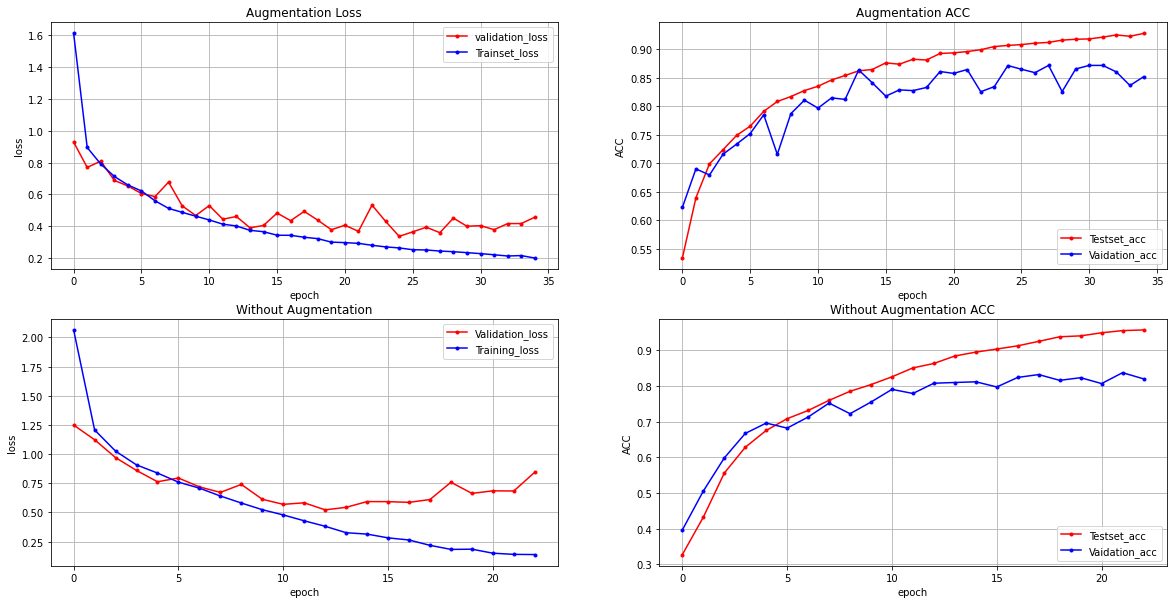

In [34]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize = (20,10))
y_vloss = history.history['val_loss']
y_loss = history.history['loss']
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
# with out augmentaion
y_vloss2 = history2.history['val_loss']
y_loss2 = history2.history['loss']
acc2 = history2.history['categorical_accuracy']
val_acc2 = history2.history['val_categorical_accuracy']

# 그래프로 표현
plt.subplot(2,2,1)
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='validation_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Augmentation Loss')
plt.subplot(2,2,2)
x_len = np.arange(len(y_loss))
plt.plot(x_len, acc, marker='.', c="red", label='Testset_acc')
plt.plot(x_len, val_acc, marker='.', c="blue", label='Vaidation_acc')
plt.legend(loc='lower right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('ACC')
plt.title('Augmentation ACC')

plt.subplot(2,2,3)
x_len = np.arange(len(y_loss2))
plt.plot(x_len, y_vloss2, marker='.', c="red", label='Validation_loss')
plt.plot(x_len, y_loss2, marker='.', c="blue", label='Training_loss')
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Without Augmentation")

plt.subplot(2,2,4)
x_len = np.arange(len(acc2))
plt.plot(x_len, acc2, marker='.', c="red", label='Testset_acc')
plt.plot(x_len, val_acc2, marker='.', c="blue", label='Vaidation_acc')
plt.legend(loc='lower right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('ACC')
plt.title('Without Augmentation ACC')

plt.show()

# Evaluate

In [39]:
model.evaluate(test_generator) # augmenation

80/80 [==============================] - 5s 60ms/step - loss: 0.3225 - categorical_accuracy: 0.8865


[0.32248446345329285, 0.8865000009536743]

In [40]:
model2.evaluate(test_generator) # Not augmentation

80/80 [==============================] - 5s 60ms/step - loss: 0.6609 - categorical_accuracy: 0.8510


[0.6609358787536621, 0.8510000109672546]

## test data evaluate결과 augmentation을 적용한 데이터로 학습한 모델의 결과가 3% 더 높음

#Predict

In [62]:
#plot
class_names= ['airplane', 'automobile', 'bird', 'cat']
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img/255, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                )

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(4), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [53]:
image,label = next(test_generator)

In [54]:
image.shape

(50, 150, 150, 3)

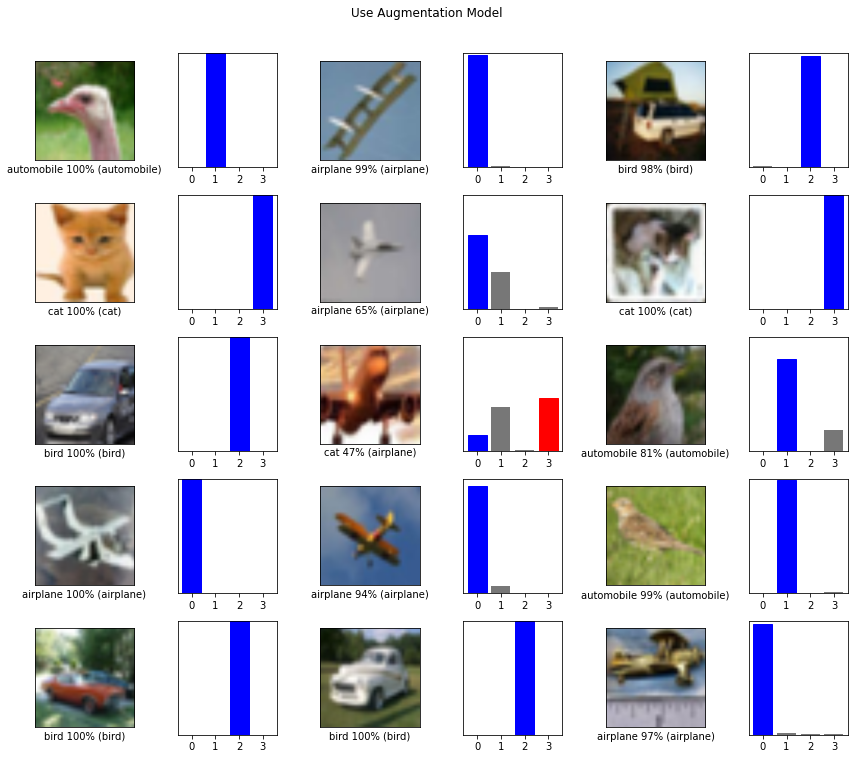

In [67]:
predictions  = model.predict(image[:15])

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], label[:15].argmax(axis=1), image[:15])
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], label[:15].argmax(axis=1))
plt.tight_layout()
plt.suptitle('Use Augmentation Model',y=1.05)
plt.show()

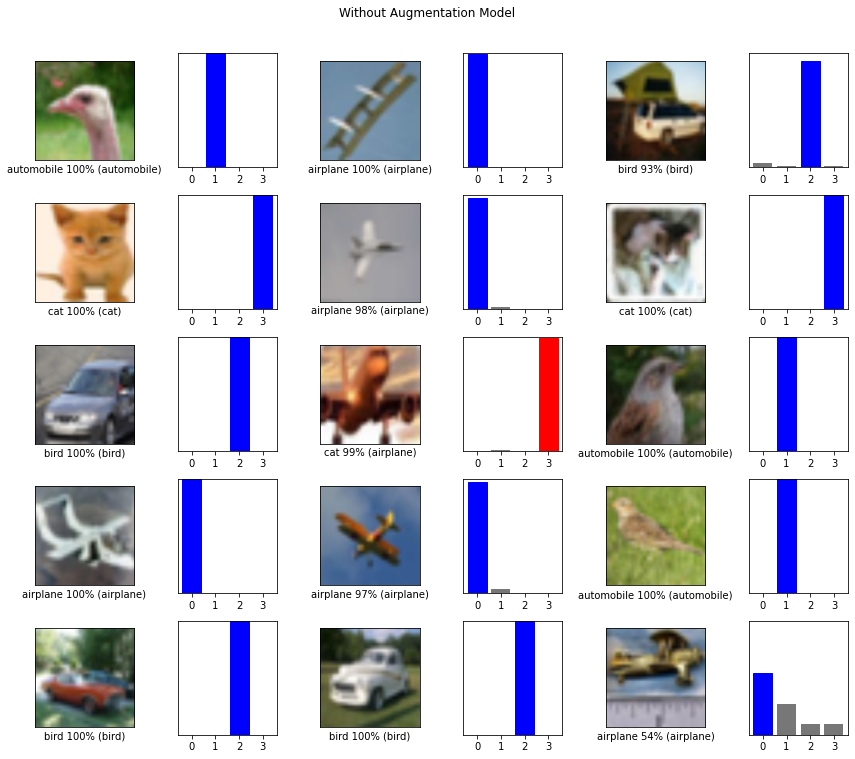

In [68]:
predictions  = model2.predict(image[:15])

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], label[:15].argmax(axis=1), image[:15])
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], label[:15].argmax(axis=1))
plt.tight_layout()
plt.suptitle('Without Augmentation Model',y=1.05)
plt.show()

# 느낀점
---
1. 딥러닝 네트워크 구조를 어떻게 하는가에 따라 모델의 성능이 매우 달라진것을 봤다.네트워크의 중요성을 깨달았다.
1. 데이터의 양이 매우 중요하다. Augmentation을 많이 하지 않았음에도 불구하고 모델의 성능이 더 잘나왔다. 
1. 하드웨어가 받쳐줘야 한다. 네트워크를 레이어를 조금 더 쌓아서 모델의 성능을 올려보려 했지만 Out of Memory가 났다. 네트워크를 설계할 때 데이터의 용량과 사용하고자하는 컴퓨터의 메모리도 고려해서 설계해야겠다. 
